In [3]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import regex as reg
import random

In [2]:
train_labels = pd.read_csv('Data/TrainLabels.csv')
submission = pd.read_csv('Data/SampleSubmission.csv')
true_labels = pd.read_csv('Data/true_labels.csv')

In [3]:
X_train = np.load('Data/X_train_final(bs).npy')
X_test = np.load('Data/X_test_final(bs).npy')

In [18]:
Y_train = train_labels.Prediction.values
true_labels = pd.read_csv('Data/true_labels.csv', header = None)
Y_test = true_labels[0].values

In [5]:
train_labels

,IdFeedBack,Prediction
0,S02_Sess01_FB001,1
1,S02_Sess01_FB002,1
2,S02_Sess01_FB003,0
3,S02_Sess01_FB004,0
4,S02_Sess01_FB005,1
...,...,...
5435,S26_Sess05_FB096,1
5436,S26_Sess05_FB097,0
5437,S26_Sess05_FB098,0
5438,S26_Sess05_FB099,0


In [19]:
training_subjects = int(16)
num_of_fb = int(340)

In [6]:
'''get_meta(labels)
Get meta data for each feedback, returns subject #, session #, and feedback #, using regex patterns

Args:
    labels: train or test labels consisting of an IdFeedBack column
    
Returns:
   subs, sess, fbs: Subjects, Sessions, and Feedbacks respectively returned as 1 dimensional array,
   meta data can be used to improve model performances. 
'''
def get_meta(labels):
    subs = []
    sess = []
    fbs = []
    for i,f in enumerate(labels.IdFeedBack.values):
        [(subject, session, feedback)] = reg.findall('S(\d\d).+s(\d\d).+FB(\d\d\d)',f)
        subs.append(int(subject)) 
        sess.append(int(session)) 
        fbs.append(int(feedback))
    return subs, sess, fbs

In [7]:
train_subs, train_sessions, train_fbs = get_meta(train_labels)
test_subs, test_sessions, test_fbs = get_meta(submission)

In [8]:
df_train = pd.DataFrame(X_train)
df_train['Subject'] = train_subs
df_train['Session'] = train_sessions
df_train['Feedback'] = train_fbs

In [9]:
df_test = pd.DataFrame(X_test)
df_test['Subject'] = test_subs
df_test['Session'] = test_sessions
df_test['Feedback'] = test_fbs

In [10]:
'''extract_sub(df_X, train_sub)
Random selection of train_sub subjects, (16 - train_sub) are the number of subjects used for test data. Use train_subs
to create train_subs random values ranging from 0 to 16, those subjects will now be training, while rest will be testing.

Args:
    df_X: DataFrame of input data, consisting of 16 total subjects, 340 feedbacks each
    train_sub: number of subjects used for training
    
Returns:
    train_x, train_y, test_x, test_y: train and test data for x and y respectively.
'''
def extract_sub(df_X, train_sub):
    train_subs = random.sample(list(np.arange(0,training_subjects)),train_sub)
    array = np.array(df_X).reshape(training_subjects,num_of_fb,df_X.shape[1])
    array_Y = Y_train.reshape(training_subjects,num_of_fb)
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for j, i in enumerate(np.arange(0,training_subjects)):
        if i in train_subs:
            if len(train_x) == 0:
                train_x = array[i,:,:].reshape(num_of_fb,df_X.shape[1])
                train_y = np.append(train_y, array_Y[i,:])

            else:
                train_x = np.append(train_x, array[i,:,:].reshape(num_of_fb,df_X.shape[1]), axis = 0)
                train_y = np.append(train_y, array_Y[i,:])
        else:
            if len(test_x) == 0:
                test_x = array[i,:,:].reshape(num_of_fb,df_X.shape[1])
                test_y = np.append(test_y, array_Y[i,:])
            else:
                test_x = np.append(test_x, array[i,:,:].reshape(num_of_fb,df_X.shape[1]), axis = 0)
                test_y = np.append(test_y, array_Y[i,:])
    return train_x, train_y, test_x, test_y

In [13]:
train_x, train_y, test_x, test_y = extract_sub(df_train, 12)

In [ ]:
def plot_roc(y, preds, model):
    fpr, tpr, thresholds = roc_curve(y, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("max(tpr - fpr) w/ th = ", optimal_threshold)
    l1, = plt.plot([0, 1], [0, 1], '--')
    l2, = plt.plot(fpr, tpr, label = 'Random Forest')
    auc = roc_auc_score(y, preds)
    l = plt.legend([l2], [model+str(' AUC: %.2f' % auc)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [371]:
print(train_x.shape, train_y. shape)

(4080, 213) (4080,)


In [372]:
print(test_x.shape, test_y. shape)

(1360, 213) (1360,)


## Random Forests

GridsearchCV across the following parameters:

In [25]:
params = {
    'n_estimators': [100,200,500,1000],
    'max_depth' : [1,10,50,80,90,100],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
    'bootstrap' : [True,False]
}

In [26]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state=42)
cv = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=5, refit='accuracy', cv=4)
cv.fit(X_train,Y_train)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 53.2min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'boot

In [28]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
70,8.080757,0.943704,2.876540,0.243506,True,10,4,10,500,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.707568,0.702425,0.712288,0.714496,0.709191,0.004641,1
66,7.984007,0.980470,3.949500,0.236821,True,10,4,5,500,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.707568,0.700955,0.711553,0.711553,0.707904,0.004331,2
62,8.534504,0.465954,2.817255,0.246316,True,10,4,2,500,"{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.707568,0.700955,0.711553,0.711553,0.707904,0.004331,2
245,0.740999,0.196961,0.401750,0.341444,False,1,4,5,200,"{'bootstrap': False, 'max_depth': 1, 'min_samp...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,4
243,3.885750,0.387456,0.644249,0.345870,False,1,4,2,1000,"{'bootstrap': False, 'max_depth': 1, 'min_samp...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,7.270500,0.398241,2.748500,0.353493,False,100,1,5,100,"{'bootstrap': False, 'max_depth': 100, 'min_sa...",0.706098,0.659809,0.711553,0.699779,0.694301,0.020355,428
412,7.048999,0.312515,2.727266,0.332651,False,100,2,5,100,"{'bootstrap': False, 'max_depth': 100, 'min_sa...",0.706833,0.653931,0.707138,0.706402,0.693566,0.022896,429
340,7.959878,0.203409,3.798383,0.651506,False,80,2,5,100,"{'bootstrap': False, 'max_depth': 80, 'min_sam...",0.706833,0.653931,0.707138,0.706402,0.693566,0.022896,429
304,7.796012,0.640758,4.149754,0.605184,False,50,2,5,100,"{'bootstrap': False, 'max_depth': 50, 'min_sam...",0.706833,0.653931,0.707138,0.706402,0.693566,0.022896,429


In [29]:
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])

best params:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}


Random Forests with no Meta Data:

In [130]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=500, min_samples_split=10,
                                      min_samples_leaf=4, max_depth = 10, random_state=42)
clf.fit(X_train, Y_train)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 2 seconds


In [131]:
preds = clf.predict_proba(X_test)[:,1]

max(tpr - fpr) w/ th =  0.6057215071106236


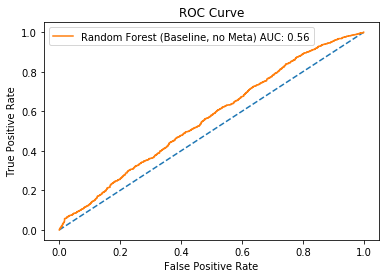

In [132]:
plot_roc(Y_test, preds, 'Random Forest (Baseline, no Meta)')

In [133]:
submission['Prediction'] = preds
submission.to_csv('RF_Preds(B).csv', index=None)

Predicting with Meta Data: Searching for parameters for Meta Case aswell

In [40]:
X_train_meta  = np.array(df_train)
X_test_meta = np.array(df_test)

In [42]:
params = {
    'n_estimators': [200,500],
    'max_depth' : [1,10,50,100],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
    'bootstrap' : [True]
}

In [134]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state=42)
cv = GridSearchCV(clf, param_grid=params, scoring='accuracy', n_jobs=-1, verbose=5, refit='accuracy', cv=4)
cv.fit(X_train_meta,Y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  4.8min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'boot

In [135]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'bootstrap': True, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.589250,0.113103,0.305750,0.143340,True,1,1,2,200,"{'bootstrap': True, 'max_depth': 1, 'min_sampl...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
17,2.788247,0.431150,0.981500,0.458781,True,1,4,10,500,"{'bootstrap': True, 'max_depth': 1, 'min_sampl...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
15,1.440999,0.137927,0.214501,0.080959,True,1,4,5,500,"{'bootstrap': True, 'max_depth': 1, 'min_sampl...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
14,1.006501,0.448363,0.529249,0.407376,True,1,4,5,200,"{'bootstrap': True, 'max_depth': 1, 'min_sampl...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
13,1.563749,0.026819,0.137750,0.024984,True,1,4,2,500,"{'bootstrap': True, 'max_depth': 1, 'min_sampl...",0.707568,0.707568,0.707873,0.707873,0.707721,0.000153,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,7.244000,1.345618,2.821250,1.621625,True,50,1,5,200,"{'bootstrap': True, 'max_depth': 50, 'min_samp...",0.707568,0.643644,0.713760,0.713760,0.694669,0.029582,67
56,7.783381,1.747625,2.384376,1.731964,True,100,1,5,200,"{'bootstrap': True, 'max_depth': 100, 'min_sam...",0.707568,0.643644,0.713760,0.713760,0.694669,0.029582,67
60,7.064753,2.009065,2.598378,1.821758,True,100,2,2,200,"{'bootstrap': True, 'max_depth': 100, 'min_sam...",0.707568,0.648788,0.713024,0.709345,0.694669,0.026576,67
36,7.168764,0.339213,2.197500,1.234033,True,50,1,2,200,"{'bootstrap': True, 'max_depth': 50, 'min_samp...",0.707568,0.641440,0.710817,0.716703,0.694118,0.030604,71


In [45]:
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])

best params:  {'bootstrap': True, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [136]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=200, min_samples_split=2,
                                      min_samples_leaf=1, max_depth = 1, random_state=42)
clf.fit(X_train_meta, Y_train)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 0 seconds


In [137]:
preds = clf.predict_proba(X_test_meta)[:,1]

max(tpr - fpr) w/ th =  0.7269475912190585


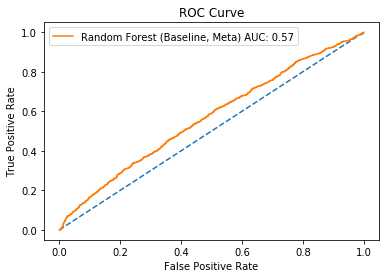

In [138]:
plot_roc(Y_test, preds, 'Random Forest (Baseline, Meta)')

In [140]:
preds

array([0.69482894, 0.69612225, 0.75651868, ..., 0.72930369, 0.70842168,
       0.6947749 ])

In [139]:
submission['Prediction'] = preds
submission.to_csv('RF_Preds(BM).csv', index=None)

Non-Baseline corrected version:

In [141]:
X_train1 = np.load('Data/X_train_final.npy')
X_test1 = np.load('Data/X_test_final.npy')

In [142]:
train_subs, train_sessions, train_fbs = get_meta(train_labels)
test_subs, test_sessions, test_fbs = get_meta(submission)

In [143]:
df_train1 = pd.DataFrame(X_train1)
df_train1['Subject'] = train_subs
df_train1['Session'] = train_sessions
df_train1['Feedback'] = train_fbs

In [144]:
df_test1 = pd.DataFrame(X_test1)
df_test1['Subject'] = test_subs
df_test1['Session'] = test_sessions
df_test1['Feedback'] = test_fbs

In [145]:
X_train_meta1 = np.array(df_train1)
X_test_meta1 = np.array(df_test1)

In [146]:
X_test_meta1.shape

(3400, 213)

In [147]:
start = time.time()
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=200, min_samples_split=2,
                                      min_samples_leaf=1, max_depth = 1, random_state=42)
clf.fit(X_train_meta1, Y_train)

now = time.time()
print('Elapsed Time: ' + str(int(now-start)) + ' seconds')

Elapsed Time: 0 seconds


In [148]:
preds = clf.predict_proba(X_test_meta1)[:,1]

max(tpr - fpr) w/ th =  0.7061134986920794


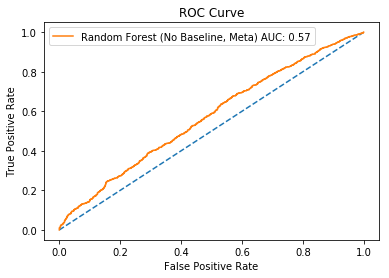

In [149]:
plot_roc(Y_test, preds, 'Random Forest (No Baseline, Meta)')

In [151]:
submission['Prediction'] = preds
submission.to_csv('RF_Preds(M).csv', index = None)

In [152]:
clf = ensemble.RandomForestClassifier(n_jobs = -1, n_estimators=500, min_samples_split=10,
                                      min_samples_leaf=4, max_depth = 10, random_state=42)
clf.fit(X_train1, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [153]:
probs = clf.predict_proba(X_test1)[:,1]
probs

array([0.63968797, 0.64308983, 0.67795849, ..., 0.5801883 , 0.65562833,
       0.65736094])

max(tpr - fpr) w/ th =  0.6065256976526385


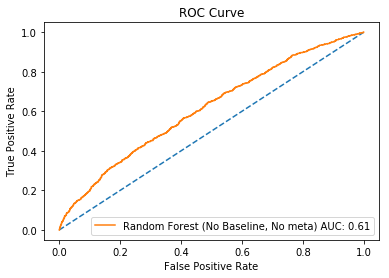

In [154]:
plot_roc(Y_test, probs, 'Random Forest (No Baseline, No meta)')

In [155]:
submission['Prediction'] = probs
submission.to_csv('RF_Preds.csv', index = None)

## ElasticNet

Same as above, 4 predictions will be created with combinations of Baseline_Correction = [True, False], and Meta_included = [True, False].

In [156]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
         'l1_ratio': [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1],
         'normalize': ['True', 'False']}

In [161]:
en = ElasticNet()
cv = GridSearchCV(en, param_grid=params, n_jobs=-1, verbose=5, cv=4)
cv.fit(X_train, Y_train)

Fitting 4 folds for each of 154 candidates, totalling 616 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 601 out of 616 | elapsed:   32.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:   34.6s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8, 0.9, 1],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [162]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'alpha': 0.0001, 'l1_ratio': 0.8, 'normalize': 'False'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
17,0.215750,0.027589,0.002500,0.000500,0.0001,0.8,False,"{'alpha': 0.0001, 'l1_ratio': 0.8, 'normalize'...",-0.013024,-0.100728,0.082873,0.055747,0.006217,0.070952,1
16,0.215997,0.025777,0.002251,0.000435,0.0001,0.8,True,"{'alpha': 0.0001, 'l1_ratio': 0.8, 'normalize'...",-0.013024,-0.100728,0.082873,0.055747,0.006217,0.070952,1
15,0.217249,0.028910,0.002251,0.000433,0.0001,0.7,False,"{'alpha': 0.0001, 'l1_ratio': 0.7, 'normalize'...",-0.014065,-0.101451,0.083221,0.056994,0.006175,0.071610,3
14,0.217998,0.030142,0.002500,0.000501,0.0001,0.7,True,"{'alpha': 0.0001, 'l1_ratio': 0.7, 'normalize'...",-0.014065,-0.101451,0.083221,0.056994,0.006175,0.071610,3
18,0.196497,0.037003,0.002252,0.000433,0.0001,0.9,True,"{'alpha': 0.0001, 'l1_ratio': 0.9, 'normalize'...",-0.012081,-0.100570,0.082742,0.054308,0.006100,0.070546,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.084249,0.007694,0.002750,0.000435,0.1,0.6,True,"{'alpha': 0.1, 'l1_ratio': 0.6, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57
77,0.083750,0.008870,0.003500,0.000497,0.1,0.5,False,"{'alpha': 0.1, 'l1_ratio': 0.5, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57
152,0.086751,0.007980,0.002501,0.000500,100,1,True,"{'alpha': 100, 'l1_ratio': 1, 'normalize': 'Tr...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57
86,0.080500,0.002871,0.002500,0.000500,0.1,1,True,"{'alpha': 0.1, 'l1_ratio': 1, 'normalize': 'Tr...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57


In [217]:
en = ElasticNet(random_state = 42, normalize='True', alpha = 0.0001, l1_ratio = 0.8)
en.fit(X_train, Y_train)
probs = en.predict(X_test)

In [218]:
probs

array([0.67054569, 0.48695707, 0.67147625, ..., 0.65921638, 0.66715833,
       0.50207534])

max(tpr - fpr) w/ th =  0.5650510626739527


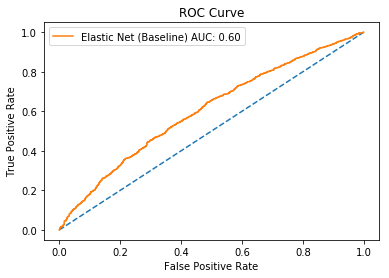

In [219]:
plot_roc(Y_test, probs, 'Elastic Net (Baseline)')

In [180]:
submission['Prediction'] = probs
submission.to_csv('Elastic(B).csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.670546
1,S01_Sess01_FB002,0.486957
2,S01_Sess01_FB003,0.671476
3,S01_Sess01_FB004,0.573343
4,S01_Sess01_FB005,0.663133
...,...,...
3395,S25_Sess05_FB096,0.684118
3396,S25_Sess05_FB097,0.594811
3397,S25_Sess05_FB098,0.659216
3398,S25_Sess05_FB099,0.667158


Applying GridsearchCV again to search for best params when Meta data is included:

In [181]:
en = ElasticNet()
cv = GridSearchCV(en, param_grid=params, n_jobs=-1, verbose=5, cv=4)
cv.fit(X_train_meta, Y_train)

Fitting 4 folds for each of 154 candidates, totalling 616 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 616 out of 616 | elapsed:   34.4s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                      0.8, 0.9, 1],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [182]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'alpha': 0.001, 'l1_ratio': 0.1, 'normalize': 'False'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
25,0.094999,0.008398,0.002251,0.000434,0.001,0.1,False,"{'alpha': 0.001, 'l1_ratio': 0.1, 'normalize':...",-0.040458,-0.090079,0.059191,0.053576,-0.004443,0.063337,1
24,0.101750,0.005717,0.002000,0.000003,0.001,0.1,True,"{'alpha': 0.001, 'l1_ratio': 0.1, 'normalize':...",-0.040458,-0.090079,0.059191,0.053576,-0.004443,0.063337,1
23,3.627500,0.051452,0.002750,0.000828,0.001,0,False,"{'alpha': 0.001, 'l1_ratio': 0.0, 'normalize':...",-0.044409,-0.093880,0.064768,0.055286,-0.004559,0.066996,3
22,3.620251,0.055729,0.003000,0.000706,0.001,0,True,"{'alpha': 0.001, 'l1_ratio': 0.0, 'normalize':...",-0.044409,-0.093880,0.064768,0.055286,-0.004559,0.066996,3
27,0.092500,0.005724,0.002500,0.000500,0.001,0.2,False,"{'alpha': 0.001, 'l1_ratio': 0.2, 'normalize':...",-0.039117,-0.086614,0.052152,0.049074,-0.006126,0.059182,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.085750,0.001922,0.002500,0.000867,0.1,0.6,True,"{'alpha': 0.1, 'l1_ratio': 0.6, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57
77,0.084998,0.006782,0.002751,0.000433,0.1,0.5,False,"{'alpha': 0.1, 'l1_ratio': 0.5, 'normalize': '...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57
152,0.079999,0.002345,0.002501,0.000502,100,1,True,"{'alpha': 100, 'l1_ratio': 1, 'normalize': 'Tr...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57
86,0.085750,0.003633,0.002751,0.000433,0.1,1,True,"{'alpha': 0.1, 'l1_ratio': 1, 'normalize': 'Tr...",-0.063450,-0.113595,-0.027780,-0.000332,-0.051289,0.042365,57


In [255]:
en = ElasticNet(random_state = 42, normalize='True', alpha = 0.0001, l1_ratio = 0.5)
en.fit(X_train_meta, Y_train)
probs = en.predict(X_test_meta)

In [256]:
probs

array([0.79952943, 0.62489986, 0.78693878, ..., 0.62374499, 0.63638455,
       0.43718304])

max(tpr - fpr) w/ th =  0.64912018644235


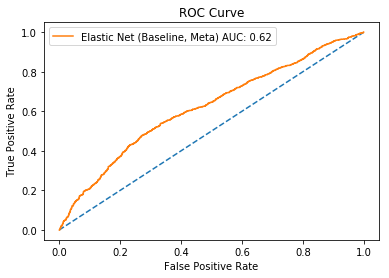

In [257]:
plot_roc(Y_test, probs, 'Elastic Net (Baseline, Meta)')

In [258]:
preds = probs

In [259]:
preds[preds >= 0.64912] = 1
preds = preds.astype(int)
preds

array([1, 0, 1, ..., 0, 0, 0])

In [260]:
print('Accuracy:')
print(accuracy_score(Y_test, preds))
print('Confusion Matrix:')
print(confusion_matrix(Y_test,preds))
print(classification_report(Y_test,preds)

Accuracy:
0.5511764705882353
Confusion Matrix:
[[ 720  269]
 [1257 1154]]
              precision    recall  f1-score   support

           0       0.36      0.73      0.49       989
           1       0.81      0.48      0.60      2411

    accuracy                           0.55      3400
   macro avg       0.59      0.60      0.54      3400
weighted avg       0.68      0.55      0.57      3400



In [241]:
submission['Prediction'] = probs
submission.to_csv('Elastic(BM).csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.799529
1,S01_Sess01_FB002,0.624900
2,S01_Sess01_FB003,0.786939
3,S01_Sess01_FB004,0.685880
4,S01_Sess01_FB005,0.771572
...,...,...
3395,S25_Sess05_FB096,0.646453
3396,S25_Sess05_FB097,0.558270
3397,S25_Sess05_FB098,0.623745
3398,S25_Sess05_FB099,0.636385


In [226]:
en = ElasticNet(random_state = 42, normalize='True', alpha = 0.0001, l1_ratio = 0.8)
en.fit(X_train1, Y_train)
probs = en.predict(X_test)

In [227]:
probs

array([0.54101953, 0.46042902, 0.67095009, ..., 0.63322863, 0.54918468,
       0.57993989])

max(tpr - fpr) w/ th =  0.5705215737083232


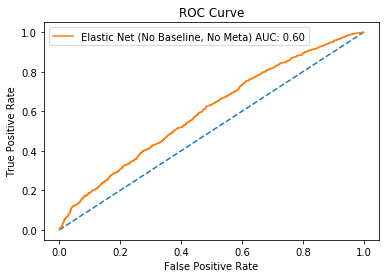

In [228]:
plot_roc(Y_test, probs, 'Elastic Net (No Baseline, No Meta)')

In [229]:
submission['Prediction'] = probs
submission.to_csv('Elastic.csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.541020
1,S01_Sess01_FB002,0.460429
2,S01_Sess01_FB003,0.670950
3,S01_Sess01_FB004,0.473771
4,S01_Sess01_FB005,0.615460
...,...,...
3395,S25_Sess05_FB096,0.553290
3396,S25_Sess05_FB097,0.606269
3397,S25_Sess05_FB098,0.633229
3398,S25_Sess05_FB099,0.549185


In [234]:
en = ElasticNet(random_state = 42, normalize='True', alpha = 0.0001, l1_ratio = 0.8)
en.fit(X_train_meta1, Y_train)
probs = en.predict(X_test_meta1)

In [235]:
probs

array([0.51060453, 0.55081008, 0.58346306, ..., 0.23681391, 0.44439949,
       0.40340149])

max(tpr - fpr) w/ th =  0.4555993617767046


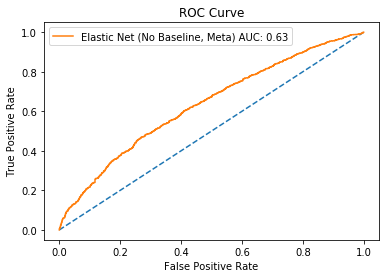

In [236]:
plot_roc(Y_test, probs, 'Elastic Net (No Baseline, Meta)')

In [237]:
submission['Prediction'] = probs
submission.to_csv('Elastic(M).csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.510605
1,S01_Sess01_FB002,0.550810
2,S01_Sess01_FB003,0.583463
3,S01_Sess01_FB004,0.525312
4,S01_Sess01_FB005,0.603893
...,...,...
3395,S25_Sess05_FB096,0.458775
3396,S25_Sess05_FB097,0.412429
3397,S25_Sess05_FB098,0.236814
3398,S25_Sess05_FB099,0.444399


## LDA

In [272]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [277]:
params = {
    'solver': ['lsqr','eigen'],
    'shrinkage' : [None, 'auto'],
    'n_components' : [5,10,15,20,25,30,35,None]
}

In [278]:
lda = LDA()
cv = GridSearchCV(lda, param_grid=params, n_jobs=-1, verbose=10, cv=4)
cv.fit(X_train, Y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 126 out of 128 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    3.8s finished
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='warn', n_jobs=-1,
             param_grid={'n_components': [5, 10, 15, 20, 25, 30, 35, None],
                         'shrinkage': [None, 'auto'],
                         'solver': ['lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [280]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'n_components': 20, 'shrinkage': 'auto', 'solver': 'eigen'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_shrinkage,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
15,0.276998,0.007452,0.001751,4.350812e-04,20,auto,eigen,"{'n_components': 20, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
27,0.274514,0.021225,0.001501,4.999640e-04,35,auto,eigen,"{'n_components': 35, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
26,0.168750,0.020426,0.002002,1.233110e-06,35,auto,lsqr,"{'n_components': 35, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
23,0.271752,0.013330,0.001250,4.336048e-04,30,auto,eigen,"{'n_components': 30, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
22,0.178502,0.011927,0.001749,8.276243e-04,30,auto,lsqr,"{'n_components': 30, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
19,0.253751,0.006178,0.001749,4.328476e-04,25,auto,eigen,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
18,0.165250,0.007293,0.001751,4.331913e-04,25,auto,lsqr,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
30,0.148501,0.006690,0.001750,4.328464e-04,None,auto,lsqr,"{'n_components': None, 'shrinkage': 'auto', 's...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
14,0.150501,0.006500,0.001501,4.997262e-04,20,auto,lsqr,"{'n_components': 20, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1
11,0.262501,0.008290,0.001250,4.324654e-04,15,auto,eigen,"{'n_components': 15, 'shrinkage': 'auto', 'sol...",0.676708,0.640705,0.699043,0.674025,0.672610,0.020831,1


In [282]:
lda = LDA(solver = 'eigen', shrinkage = 'auto', n_components=20)
lda.fit(X_train, Y_train)

D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(210, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage='auto',
                           solver='eigen', store_covariance=False, tol=0.0001)

In [283]:
probs = lda.predict_proba(X_test)[:,1]

max(tpr - fpr) w/ th =  0.0009085498824907796


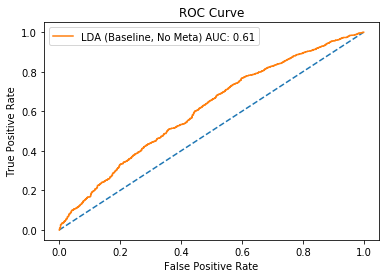

In [297]:
plot_roc(Y_test, probs, 'LDA (Baseline, No Meta)')

In [304]:
submission['Prediction'] = probs
submission.to_csv('LDA(B).csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.008733
1,S01_Sess01_FB002,0.015094
2,S01_Sess01_FB003,0.022708
3,S01_Sess01_FB004,0.015798
4,S01_Sess01_FB005,0.020965
...,...,...
3395,S25_Sess05_FB096,0.009295
3396,S25_Sess05_FB097,0.003909
3397,S25_Sess05_FB098,0.000764
3398,S25_Sess05_FB099,0.005223


Same search as above but with Meta data

In [286]:
lda = LDA()
cv = GridSearchCV(lda, param_grid=params, n_jobs=-1, verbose=10, cv=4)
cv.fit(X_train_meta, Y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 126 out of 128 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    3.7s finished
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='warn', n_jobs=-1,
             param_grid={'n_components': [5, 10, 15, 20, 25, 30, 35, None],
                         'shrinkage': [None, 'auto'],
                         'solver': ['lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [287]:
cv_results = pd.DataFrame(cv.cv_results_)
print("best params: ", cv_results.sort_values('rank_test_score').reset_index()['params'][0])
cv_results.sort_values('rank_test_score')

best params:  {'n_components': 20, 'shrinkage': 'auto', 'solver': 'eigen'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_shrinkage,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
15,0.264777,0.009681,0.001512,5.131355e-04,20,auto,eigen,"{'n_components': 20, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
27,0.264500,0.011278,0.001500,4.993692e-04,35,auto,eigen,"{'n_components': 35, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
26,0.166751,0.007326,0.001251,4.322247e-04,35,auto,lsqr,"{'n_components': 35, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
23,0.265002,0.014195,0.001750,4.315725e-04,30,auto,eigen,"{'n_components': 30, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
22,0.160501,0.007229,0.001751,4.343251e-04,30,auto,lsqr,"{'n_components': 30, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
19,0.280501,0.014396,0.000999,1.872573e-06,25,auto,eigen,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
18,0.156753,0.002164,0.002249,4.336091e-04,25,auto,lsqr,"{'n_components': 25, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
30,0.152965,0.012138,0.001252,4.341600e-04,None,auto,lsqr,"{'n_components': None, 'shrinkage': 'auto', 's...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
14,0.159753,0.006221,0.001999,1.998312e-06,20,auto,lsqr,"{'n_components': 20, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1
11,0.271515,0.009539,0.001749,4.329471e-04,15,auto,eigen,"{'n_components': 15, 'shrinkage': 'auto', 'sol...",0.690669,0.642910,0.698308,0.671818,0.675919,0.021365,1


In [288]:
lda = LDA(solver = 'eigen', shrinkage = 'auto', n_components=20)
lda.fit(X_train_meta, Y_train)

D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(213, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage='auto',
                           solver='eigen', store_covariance=False, tol=0.0001)

In [289]:
probs = lda.predict_proba(X_test_meta)[:,1]

max(tpr - fpr) w/ th =  0.8884120950968268


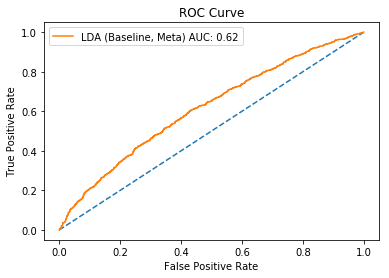

In [292]:
plot_roc(Y_test, probs, 'LDA (Baseline, Meta)')

In [293]:
submission['Prediction'] = probs
submission.to_csv('LDA(BM).csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.982200
1,S01_Sess01_FB002,0.959654
2,S01_Sess01_FB003,0.968915
3,S01_Sess01_FB004,0.938331
4,S01_Sess01_FB005,0.940669
...,...,...
3395,S25_Sess05_FB096,0.900016
3396,S25_Sess05_FB097,0.862747
3397,S25_Sess05_FB098,0.924560
3398,S25_Sess05_FB099,0.881018


In [294]:
lda = LDA(solver = 'eigen', shrinkage = 'auto', n_components=20)
lda.fit(X_train1, Y_train)

D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(210, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage='auto',
                           solver='eigen', store_covariance=False, tol=0.0001)

In [295]:
probs = lda.predict_proba(X_test1)[:,1]

max(tpr - fpr) w/ th =  0.0009085498824907796


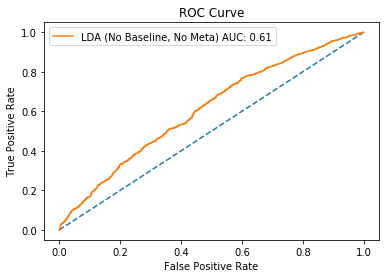

In [298]:
plot_roc(Y_test, probs, 'LDA (No Baseline, No Meta)')

In [302]:
submission['Prediction'] = probs
submission.to_csv('LDA.csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.008733
1,S01_Sess01_FB002,0.015094
2,S01_Sess01_FB003,0.022708
3,S01_Sess01_FB004,0.015798
4,S01_Sess01_FB005,0.020965
...,...,...
3395,S25_Sess05_FB096,0.009295
3396,S25_Sess05_FB097,0.003909
3397,S25_Sess05_FB098,0.000764
3398,S25_Sess05_FB099,0.005223


In [299]:
lda = LDA(solver = 'eigen', shrinkage = 'auto', n_components=20)
lda.fit(X_train_meta1, Y_train)

D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(213, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


LinearDiscriminantAnalysis(n_components=20, priors=None, shrinkage='auto',
                           solver='eigen', store_covariance=False, tol=0.0001)

In [300]:
probs = lda.predict_proba(X_test_meta1)[:,1]

max(tpr - fpr) w/ th =  0.0032893327335583814


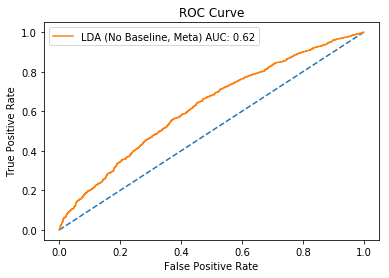

In [301]:
plot_roc(Y_test, probs, 'LDA (No Baseline, Meta)')

In [303]:
submission['Prediction'] = probs
submission.to_csv('LDA.csv(M)', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.008733
1,S01_Sess01_FB002,0.015094
2,S01_Sess01_FB003,0.022708
3,S01_Sess01_FB004,0.015798
4,S01_Sess01_FB005,0.020965
...,...,...
3395,S25_Sess05_FB096,0.009295
3396,S25_Sess05_FB097,0.003909
3397,S25_Sess05_FB098,0.000764
3398,S25_Sess05_FB099,0.005223


In [305]:
from sklearn.linear_model import LogisticRegression

In [307]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [311]:
preds = lr.predict_proba(X_test)[:,1]

max(tpr - fpr) w/ th =  0.614233715502591


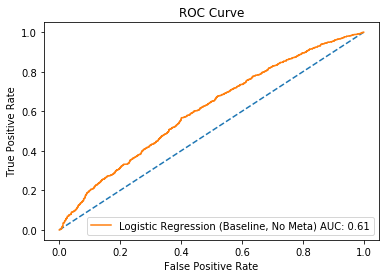

In [312]:
plot_roc(Y_test, preds, 'Logistic Regression (Baseline, No Meta)')

In [313]:
lr = LogisticRegression()
lr.fit(X_train_meta, Y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [314]:
preds = lr.predict_proba(X_test_meta)[:,1]

max(tpr - fpr) w/ th =  0.7611917150706122


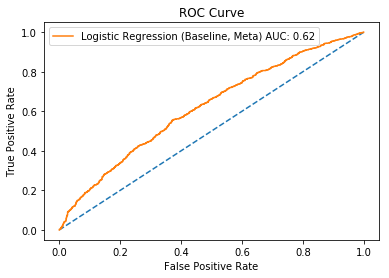

In [315]:
plot_roc(Y_test, preds, 'Logistic Regression (Baseline, Meta)')

In [316]:
submission['Prediction'] = preds
submission.to_csv('Logistic(BM).csv', index=None)
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0.944036
1,S01_Sess01_FB002,0.880756
2,S01_Sess01_FB003,0.899827
3,S01_Sess01_FB004,0.837189
4,S01_Sess01_FB005,0.829013
...,...,...
3395,S25_Sess05_FB096,0.759022
3396,S25_Sess05_FB097,0.706472
3397,S25_Sess05_FB098,0.826797
3398,S25_Sess05_FB099,0.726534


In [57]:
rf_private_scores = [0.53667, 0.53495, 0.63896, 0.56799]
rf_public_scores = [0.67946, 0.69608, 0.51319, 0.59207]

In [66]:
x = ['Baseline','Baseline/Meta','No Baseline','No Baseline/Meta']
z = rf_public_scores
y = rf_private_scores
df_test = pd.DataFrame(zip(x*4, ["Public Score"]*4+["Private Score"]*4, z+y), columns=["type", "RF", "data"])

In [67]:
df_test

,type,RF,data
0,Baseline,Public Score,0.67946
1,Baseline/Meta,Public Score,0.69608
2,No Baseline,Public Score,0.51319
3,No Baseline/Meta,Public Score,0.59207
4,Baseline,Private Score,0.53667
5,Baseline/Meta,Private Score,0.53495
6,No Baseline,Private Score,0.63896
7,No Baseline/Meta,Private Score,0.56799


In [50]:
import seaborn as sns

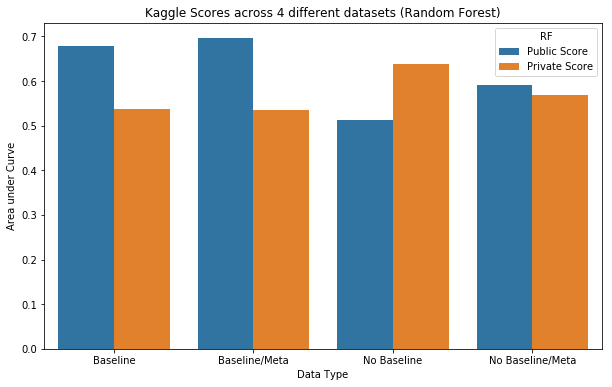

In [68]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="type", hue="RF", y="data", data=df_test)
ax.set(xlabel='Data Type', ylabel='Area under Curve')
ax.set_title('Kaggle Scores across 4 different datasets (Random Forest)')
plt.show()

In [33]:
en_private_scores = [0.59482, 0.60764, 0.58206, 0.66012]
en_public_scores = [0.63976, 0.66645, 0.67173, 0.52915]

In [69]:
x = ['Baseline','Baseline/Meta','No Baseline','No Baseline/Meta']
z = en_public_scores
y = en_private_scores
df_test = pd.DataFrame(zip(x*4, ["Public Score"]*4+["Private Score"]*4, z+y), columns=["type", "Elastic", "data"])

In [59]:
df_test

,type,score,data
0,Baseline,en_public_scores,0.63976
1,Baseline/Meta,en_public_scores,0.66645
2,No Baseline,en_public_scores,0.67173
3,No Baseline/Meta,en_public_scores,0.52915
4,Baseline,en_private_scores,0.59482
5,Baseline/Meta,en_private_scores,0.60764
6,No Baseline,en_private_scores,0.58206
7,No Baseline/Meta,en_private_scores,0.66012


In [50]:
import seaborn as sns

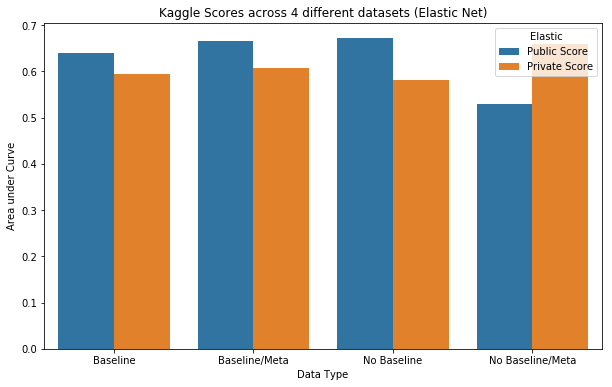

In [70]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="type", hue="Elastic", y="data", data=df_test)
ax.set(xlabel='Data Type', ylabel='Area under Curve')
ax.set_title('Kaggle Scores across 4 different datasets (Elastic Net)')
plt.show()